# CONFLUENCE Tutorial: Lumped Basin Workflow (Bow River at Banff)

This notebook walks through the complete CONFLUENCE workflow for a lumped basin model using the Bow River at Banff as an example. We'll execute each step individually to understand what's happening at each stage.

## Introduction to CONFLUENCE

CONFLUENCE (Community Optimization and Numerical Framework for Large-domain Understanding of Environmental Networks and Computational Exploration) is designed to address a fundamental challenge in hydrological modeling: the overwhelming number of decisions required to set up and run a hydrological model.

### The Challenge of Hydrological Modeling Decisions

Hydrological modeling involves numerous interconnected decisions at every stage:
- **Domain Definition**: What area should we model? How should we delineate the watershed?
- **Data Processing**: Which forcing datasets? What temporal and spatial resolution? 
- **Model Selection**: Which hydrological model? What process representations?
- **Parameterization**: Which parameters to calibrate? What are reasonable ranges?
- **Evaluation**: What metrics? Which observation datasets?

Each decision impacts the others, creating a complex decision tree that can be overwhelming for both novice and experienced modelers.

### How CONFLUENCE Helps

CONFLUENCE addresses this complexity by:
1. **Organizing the workflow** into clear, sequential steps
2. **Standardizing data structures** across different models and datasets
3. **Providing sensible defaults** while allowing full customization
4. **Maintaining detailed provenance** of all decisions made
5. **Enabling reproducibility** through comprehensive configuration management

### CONFLUENCE's Code Structure: Organized by Function

CONFLUENCE uses an object-oriented design where different aspects of hydrological modeling are handled by specialized classes called "managers". This is like having different experts, each responsible for their domain:

```python
# Each manager handles a specific task
project_manager = ProjectManager(config, logger)     # Project setup
domain_manager = DomainManager(config, logger)       # Watershed delineation  
data_manager = DataManager(config, logger)           # Data processing
model_manager = ModelManager(config, logger)         # Model operations
```

### Why This Matters

Instead of one giant script with thousands of lines, CONFLUENCE breaks the workflow into logical pieces:

```python
# Traditional approach - everything mixed together
def run_model():
    # 1000+ lines of mixed code...
    setup_directories()
    download_data()
    delineate_watershed()
    process_forcings()
    run_simulation()
    # etc...

# CONFLUENCE approach - organized by function
project_manager.setup_project()          # All project setup code in one place
domain_manager.define_domain()           # All watershed code in one place
data_manager.acquire_forcings()          # All data code in one place
model_manager.run_model()               # All model code in one place
```

This organization makes it easier to:

Find and modify specific functionality
Add new models or data sources
Debug issues in specific components
Reuse code for different projects

Throughout this tutorial, you'll see how each manager handles its part of the workflow, working together to complete the full modeling process.


## Overview of This Tutorial

We'll work through the simplest case in hydrological modeling: a lumped basin model. This treats the entire watershed as a single unit, making it an ideal starting point for understanding the CONFLUENCE workflow.

We'll run through:
1. Project setup and configuration
2. Domain definition (watershed delineation)
3. Data acquisition (forcings and attributes)
4. Model preprocessing
5. Model execution
6. Results visualization

## 1. Setup and Import Libraries

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
import contextily as cx
import xarray as xr

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Import main CONFLUENCE class
from CONFLUENCE import CONFLUENCE

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## 2. Initialize CONFLUENCE
First, let's set up our directories and load the configuration. CONFLUENCE uses a centralized configuration file that controls all aspects of the modeling workflow.

In [2]:
# Set directory paths
CONFLUENCE_CODE_DIR = confluence_path
CONFLUENCE_DATA_DIR = Path('/work/comphyd_lab/data/CONFLUENCE_data')  # ← User should modify this path

# Verify paths exist
if not CONFLUENCE_CODE_DIR.exists():
    raise FileNotFoundError(f"CONFLUENCE code directory not found: {CONFLUENCE_CODE_DIR}")

if not CONFLUENCE_DATA_DIR.exists():
    print(f"Data directory doesn't exist. Creating: {CONFLUENCE_DATA_DIR}")
    CONFLUENCE_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Load and update configuration
config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_template.yaml'

# Read config file and update paths
with open(config_path, 'r') as f:
    config_dict = yaml.safe_load(f)

config_dict['CONFLUENCE_CODE_DIR'] = str(CONFLUENCE_CODE_DIR)
config_dict['CONFLUENCE_DATA_DIR'] = str(CONFLUENCE_DATA_DIR)

# Save updated config to a temporary file
temp_config_path = CONFLUENCE_CODE_DIR / '0_config_files' / 'config_notebook.yaml'
with open(temp_config_path, 'w') as f:
    yaml.dump(config_dict, f)

# Initialize CONFLUENCE
confluence = CONFLUENCE(temp_config_path)

# Display configuration
print("=== Directory Configuration ===")
print(f"Code Directory: {CONFLUENCE_CODE_DIR}")
print(f"Data Directory: {CONFLUENCE_DATA_DIR}")
print("\n=== Key Configuration Settings ===")
print(f"Domain Name: {confluence.config['DOMAIN_NAME']}")
print(f"Pour Point: {confluence.config['POUR_POINT_COORDS']}")
print(f"Spatial Mode: {confluence.config['SPATIAL_MODE']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"Simulation Period: {confluence.config['EXPERIMENT_TIME_START']} to {confluence.config['EXPERIMENT_TIME_END']}")

12:59:45 - INFO - ============================================================


2025-05-11 12:59:45,771 - confluence_general - INFO - ============================================================


12:59:45 - INFO - CONFLUENCE Logging Initialized


2025-05-11 12:59:45,772 - confluence_general - INFO - CONFLUENCE Logging Initialized


12:59:45 - INFO - Domain: Bow_at_Banff_lumped


2025-05-11 12:59:45,774 - confluence_general - INFO - Domain: Bow_at_Banff_lumped


12:59:45 - INFO - Experiment ID: run_1


2025-05-11 12:59:45,776 - confluence_general - INFO - Experiment ID: run_1


12:59:45 - INFO - Log Level: INFO


2025-05-11 12:59:45,777 - confluence_general - INFO - Log Level: INFO


12:59:45 - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/confluence_general_Bow_at_Banff_lumped_20250511_125945.log


2025-05-11 12:59:45,779 - confluence_general - INFO - Log File: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/confluence_general_Bow_at_Banff_lumped_20250511_125945.log


12:59:45 - INFO - ============================================================


2025-05-11 12:59:45,780 - confluence_general - INFO - ============================================================


12:59:45 - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/config_Bow_at_Banff_lumped_20250511_125945.yaml


2025-05-11 12:59:45,802 - confluence_general - INFO - Configuration logged to: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/_workLog_Bow_at_Banff_lumped/config_Bow_at_Banff_lumped_20250511_125945.yaml


12:59:45 - INFO - Initializing CONFLUENCE system


2025-05-11 12:59:45,807 - confluence_general - INFO - Initializing CONFLUENCE system


12:59:45 - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_notebook.yaml


2025-05-11 12:59:45,808 - confluence_general - INFO - Configuration loaded from: /home/darri.eythorsson/code/CONFLUENCE/0_config_files/config_notebook.yaml


12:59:45 - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


2025-05-11 12:59:45,810 - confluence_general - INFO - Initializing VariableHandler for dataset: ERA5 and model: SUMMA


12:59:46 - INFO - CONFLUENCE system initialized successfully


2025-05-11 12:59:46,143 - confluence_general - INFO - CONFLUENCE system initialized successfully


=== Directory Configuration ===
Code Directory: /home/darri.eythorsson/code/CONFLUENCE
Data Directory: /work/comphyd_lab/data/CONFLUENCE_data

=== Key Configuration Settings ===
Domain Name: Bow_at_Banff_lumped
Pour Point: 51.1722/-115.5717
Spatial Mode: Lumped
Model: SUMMA
Simulation Period: 2018-01-01 01:00 to 2022-12-31 23:00


## 3. Step 1: Project Setup - Organizing the Modeling Workflow
The first step in any CONFLUENCE workflow is to establish a well-organized project structure. This might seem trivial, but it's crucial for:

Maintaining consistency across different experiments
Ensuring all components can find required files
Enabling reproducibility
Facilitating collaboration

In [3]:
# Step 1: Project Initialization
print("=== Step 1: Project Initialization ===")

# Setup project
project_dir = confluence.managers['project'].setup_project()

# Create pour point
pour_point_path = confluence.managers['project'].create_pour_point()

# List created directories
print("\nCreated directories:")
for item in sorted(project_dir.iterdir()):
    if item.is_dir():
        print(f"  📁 {item.name}")

print("\nDirectory purposes:")
print("  📁 shapefiles: Domain geometry (watershed, pour points, river network)")
print("  📁 attributes: Static characteristics (elevation, soil, land cover)")
print("  📁 forcing: Meteorological inputs (precipitation, temperature)")
print("  📁 simulations: Model outputs")
print("  📁 evaluation: Performance metrics and comparisons")
print("  📁 plots: Visualizations")
print("  📁 optimisation: Calibration results")

=== Step 1: Project Initialization ===
12:59:46 - INFO - Setting up project for domain: Bow_at_Banff_lumped


2025-05-11 12:59:46,158 - confluence_general - INFO - Setting up project for domain: Bow_at_Banff_lumped


12:59:46 - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped


2025-05-11 12:59:46,166 - confluence_general - INFO - Project directory created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped
2025-05-11 12:59:46,352 - pyogrio._io - INFO - Created 1 records


12:59:46 - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp


2025-05-11 12:59:46,355 - confluence_general - INFO - Pour point shapefile created successfully: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp



Created directories:
  📁 _workLog_Bow_at_Banff_lumped
  📁 attributes
  📁 documentation
  📁 observations
  📁 optimisation
  📁 shapefiles

Directory purposes:
  📁 shapefiles: Domain geometry (watershed, pour points, river network)
  📁 attributes: Static characteristics (elevation, soil, land cover)
  📁 forcing: Meteorological inputs (precipitation, temperature)
  📁 simulations: Model outputs
  📁 evaluation: Performance metrics and comparisons
  📁 plots: Visualizations
  📁 optimisation: Calibration results


## 5. Step 2: Geospatial Domain Definition and Analysis
Before we can delineate the watershed, we need elevation data. CONFLUENCE also acquires soil and land cover data at this stage for later use in the model.

In [4]:
# Step 2: Geospatial Domain Definition and Analysis
print("=== Step 2: Geospatial Domain Definition and Analysis ===")

# Acquire attributes
print("Acquiring geospatial attributes (DEM, soil, land cover)...")
confluence.managers['data'].acquire_attributes()

# Define domain
print(f"\nDelineating watershed using method: {confluence.config['DOMAIN_DEFINITION_METHOD']}")
watershed_path = confluence.managers['domain'].define_domain()

# Discretize domain
print(f"\nCreating HRUs using method: {confluence.config['DOMAIN_DISCRETIZATION']}")
hru_path = confluence.managers['domain'].discretize_domain()

# Check outputs
print("\nDomain definition complete:")
print(f"  - Watershed defined: {watershed_path is not None}")
print(f"  - HRUs created: {hru_path is not None}")

=== Step 2: Geospatial Domain Definition and Analysis ===
Acquiring geospatial attributes (DEM, soil, land cover)...
12:59:46 - INFO - Starting attribute acquisition


2025-05-11 12:59:46,367 - confluence_general - INFO - Starting attribute acquisition


12:59:46 - INFO - Acquiring elevation data


2025-05-11 12:59:46,371 - confluence_general - INFO - Acquiring elevation data


extract-gis.sh: WARNING! --account not provided, using `rpp-kshook` by default.
(2025-05-11 18:59:49) merit_hydro.sh: processing MERIT-Hydro GeoTIFF(s)...
(2025-05-11 18:59:49) merit_hydro.sh: creating cache directory under /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 18:59:49) merit_hydro.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem
(2025-05-11 18:59:49) merit_hydro.sh: untarring MERIT-Hydro variables under /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 19:00:58) merit_hydro.sh: subsetting GeoTIFFs under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists


(2025-05-11 19:00:59) merit_hydro.sh: deleting temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 19:00:59) merit_hydro.sh: temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped are removed
(2025-05-11 19:00:59) merit_hydro.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem
13:00:59 - INFO - gistool completed successfully.


2025-05-11 13:00:59,676 - confluence_general - INFO - gistool completed successfully.


13:00:59 - INFO - Geospatial data acquisition process completed


2025-05-11 13:00:59,678 - confluence_general - INFO - Geospatial data acquisition process completed


13:00:59 - INFO - Acquiring land cover data


2025-05-11 13:00:59,680 - confluence_general - INFO - Acquiring land cover data


extract-gis.sh: WARNING! --account not provided, using `rpp-kshook` by default.
(2025-05-11 19:01:03) modis.sh: processing MODIS HDF(s)...
(2025-05-11 19:01:03) modis.sh: creating cache directory under /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 19:01:03) modis.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass
(2025-05-11 19:01:03) modis.sh: building virtual format (.vrt) of MODIS HDFs under /home/darri.eythorsson/cache_Bow_at_Banff_lumped


ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PROJ: sinu: Invalid latitude
ERROR 1: PRO

(2025-05-11 19:02:17) modis.sh: subsetting HDFs in GeoTIFF format under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass
(2025-05-11 19:02:20) modis.sh: deleting temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 19:02:20) modis.sh: temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped are removed
(2025-05-11 19:02:20) modis.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass
13:02:20 - INFO - gistool completed successfully.


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists
2025-05-11 13:02:20,730 - confluence_general - INFO - gistool completed successfully.


13:02:20 - INFO - Geospatial data acquisition process completed


2025-05-11 13:02:20,733 - confluence_general - INFO - Geospatial data acquisition process completed


13:02:20 - INFO - Calculating land cover mode across years


2025-05-11 13:02:20,735 - confluence_general - INFO - Calculating land cover mode across years


Mode calculation complete. Result saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/landclass/domain_Bow_at_Banff_lumped_land_classes.tif
13:02:44 - INFO - Acquiring soil class data


2025-05-11 13:02:44,866 - confluence_general - INFO - Acquiring soil class data


extract-gis.sh: WARNING! --account not provided, using `rpp-kshook` by default.
(2025-05-11 19:02:48) soil_class.sh: processing Wouter's wonderful soil_class GeoTIFF(s)...
(2025-05-11 19:02:48) soil_class.sh: creating output directory under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/soilclass
(2025-05-11 19:02:48) soil_class.sh: subsetting GeoTIFFs under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/soilclass
(2025-05-11 19:02:49) soil_class.sh: deleting temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped
(2025-05-11 19:02:49) soil_class.sh: temporary files from /home/darri.eythorsson/cache_Bow_at_Banff_lumped are removed
(2025-05-11 19:02:49) soil_class.sh: results are produced under /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/soilclass
13:02:49 - INFO - gistool completed successfully.


mkdir: cannot create directory ‘/home/darri.eythorsson/empty_dir’: File exists
2025-05-11 13:02:49,298 - confluence_general - INFO - gistool completed successfully.


13:02:49 - INFO - Geospatial data acquisition process completed


2025-05-11 13:02:49,299 - confluence_general - INFO - Geospatial data acquisition process completed


13:02:49 - INFO - Attribute acquisition completed successfully


2025-05-11 13:02:49,301 - confluence_general - INFO - Attribute acquisition completed successfully



Delineating watershed using method: lumped
13:02:49 - INFO - Domain definition workflow starting with: lumped


2025-05-11 13:02:49,303 - confluence_general - INFO - Domain definition workflow starting with: lumped


13:02:49 - INFO - Starting geofabric lumped delineation


2025-05-11 13:02:49,304 - confluence_general - INFO - Starting geofabric lumped delineation


13:02:49 - INFO - Geofabric delineation completed successfully


2025-05-11 13:02:49,306 - confluence_general - INFO - Geofabric delineation completed successfully


13:02:49 - INFO - Starting lumped watershed delineation for Bow_at_Banff_lumped


2025-05-11 13:02:49,308 - confluence_general - INFO - Starting lumped watershed delineation for Bow_at_Banff_lumped


PitRemove version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif has geographic coordinate system.
Nodata value input to create partition from file: -9999.000000
Nodata value recast to float used in partition raster: -9999.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Processes: 1
Header read time: 0.024342
Data read time: 0.071201
Compute time: 0.289225
Write time: 0.111368
Total time: 0.496136
13:02:50 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif


2025-05-11 13:02:50,464 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/pitremove -z /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/attributes/elevation/dem/domain_Bow_at_Banff_lumped_elv.tif -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif


D8FlowDir version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif has geographic coordinate system.
Nodata value input to create partition from file: -300000000549775575777803994281145270272.000000
Nodata value recast to float used in partition raster: -300000000549775575777803994281145270272.000000


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
All slopes evaluated. 28666 flats to resolve.
Draining flats towards lower adjacent terrain
...........................................................................
Draining flats away from higher adjacent terrain
.

Processors: 1
Header read time: 0.021994
Data read time: 0.035165
Compute Slope time: 0.290281
Write Slope time: 0.138673
Resolve Flat time: 0.699942
Write Flat time: 0.057546
Total time: 1.243600
13:02:52 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/sd8.tif


.....
Setting directions
Iteration complete. Number of flats remaining: 95
Draining flats towards lower adjacent terrain
...
Draining flats away from higher adjacent terrain
..
Setting directions
2025-05-11 13:02:52,165 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/d8flowdir -fel /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/fel.tif -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -sd8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/sd8.tif


AreaD8 version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.


Number of Processes: 1
Read time: 0.032343
Compute time: 0.333770
Write time: 0.078144
Total time: 0.444257
13:02:53 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif


2025-05-11 13:02:53,069 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/aread8 -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -ad8 /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif


Threshold version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif has geographic coordinate system.
Nodata value input to create partition from file: -1.000000
Nodata value recast to float used in partition raster: -1.000000
Compute time: 0.017449
13:02:53 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -thresh 100


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-11 13:02:53,641 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/threshold -ssa /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/ad8.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -thresh 100


MoveOutletsToStreams version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
om Total time: 0.101149
13:02:54 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_poin

This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-11 13:02:54,191 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/moveoutletstostrm -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -src /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/src.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/pour_point/Bow_at_Banff_lumped_pourPoint.shp -om /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp


Gage Watershed version 5.3.9
Input file /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif has geographic coordinate system.
Nodata value input to create partition from file: -32768.000000
Nodata value recast to int16_t used in partition raster: -32768
Size: 1
Read time: 0.042017
Compute time: 0.082079
Write time: 0.048758
Total time: 0.172853
13:02:54 - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gagewatershed -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp -gw /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed.tif -id /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed_id.txt


This run may take on the order of 1 minutes to complete.
This estimate is very approximate. 
Run time is highly uncertain as it depends on the complexity of the input data 
and speed and memory of the computer. This estimate is based on our testing on 
a dual quad core Dell Xeon E5405 2.0GHz PC with 16GB RAM.
2025-05-11 13:02:54,802 - confluence_general - INFO - Completed TauDEM step: mpirun -n 1 /work/comphyd_lab/data/CONFLUENCE_data/installs/TauDEM/bin/gagewatershed -p /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/p.tif -o /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/om.shp -gw /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed.tif -id /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/tempdir/watershed_id.txt
2025-05-11 13:02:55,030 - pyogrio._io - INFO - Created 1 records


13:02:55 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shp


2025-05-11 13:02:55,037 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shp


13:02:55 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shx


2025-05-11 13:02:55,040 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.shx


13:02:55 - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.dbf


2025-05-11 13:02:55,043 - confluence_general - INFO - Removed temporary file: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped_temp.dbf


13:02:55 - INFO - Filtered watershed shapefile created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-11 13:02:55,044 - confluence_general - INFO - Filtered watershed shapefile created at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 13:02:55,221 - pyogrio._io - INFO - Created 1 records


13:02:55 - INFO - Updated watershed shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-11 13:02:55,224 - confluence_general - INFO - Updated watershed shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
2025-05-11 13:02:55,257 - pyogrio._io - INFO - Created 1 records


13:02:55 - INFO - Created river network shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


2025-05-11 13:02:55,260 - confluence_general - INFO - Created river network shapefile at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 13:02:55,276 - pyogrio._io - INFO - Created 1 records


13:02:55 - INFO - Updated river basins shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp


2025-05-11 13:02:55,279 - confluence_general - INFO - Updated river basins shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_basins/Bow_at_Banff_lumped_riverBasins_lumped.shp
2025-05-11 13:02:55,296 - pyogrio._io - INFO - Created 1 records


13:02:55 - INFO - Updated river network shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


2025-05-11 13:02:55,298 - confluence_general - INFO - Updated river network shapefile with required fields at: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/river_network/Bow_at_Banff_lumped_riverNetwork_lumped.shp


13:02:55 - INFO - Domain definition completed using method: lumped


2025-05-11 13:02:55,300 - confluence_general - INFO - Domain definition completed using method: lumped


13:02:55 - INFO - Creating domain visualization...


2025-05-11 13:02:55,301 - confluence_general - INFO - Creating domain visualization...


13:02:56 - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


2025-05-11 13:02:56,232 - confluence_general - INFO - Domain map saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


13:02:56 - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


2025-05-11 13:02:56,234 - confluence_general - INFO - Domain visualization created: /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/domain/domain_map.png


13:02:56 - INFO - Domain definition workflow finished


2025-05-11 13:02:56,236 - confluence_general - INFO - Domain definition workflow finished



Creating HRUs using method: GRUs
13:02:56 - INFO - Discretizing domain using method: GRUs


2025-05-11 13:02:56,238 - confluence_general - INFO - Discretizing domain using method: GRUs


13:02:56 - INFO - Starting domain discretization using method: grus


2025-05-11 13:02:56,240 - confluence_general - INFO - Starting domain discretization using method: grus


13:02:56 - INFO - Step 1/2: Running discretization method


2025-05-11 13:02:56,242 - confluence_general - INFO - Step 1/2: Running discretization method


13:02:56 - INFO - config domain name Bow_at_Banff_lumped


2025-05-11 13:02:56,244 - confluence_general - INFO - config domain name Bow_at_Banff_lumped


13:02:56 - INFO - Calculating mean elevation for each HRU


2025-05-11 13:02:56,252 - confluence_general - INFO - Calculating mean elevation for each HRU
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
/home/darri.eythorsson/code/CONFLUENCE/utils/geospatial/discretization_utils.py:208: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids_utm = gru_gdf.geometry.centroid
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages

13:02:56 - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


2025-05-11 13:02:56,700 - confluence_general - INFO - GRUs saved as HRUs to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


13:02:57 - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/catchment/Bow_at_Banff_lumped_HRUs_as_GRUs.png


2025-05-11 13:02:57,815 - confluence_general - INFO - HRU plot saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/plots/catchment/Bow_at_Banff_lumped_HRUs_as_GRUs.png


13:02:57 - INFO - Step 2/2: Sorting catchment shape


2025-05-11 13:02:57,817 - confluence_general - INFO - Step 2/2: Sorting catchment shape


13:02:57 - INFO - Sorting catchment shape


2025-05-11 13:02:57,819 - confluence_general - INFO - Sorting catchment shape
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field GRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/work/comphyd_lab/users/darri/data/CONFLUENCE_data/installs/conf-env/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 2209951307.64184999 of field HRU_area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
2025-05-11 13:02:57,846 - pyogrio._io - INFO - Created 1 records


13:02:57 - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


2025-05-11 13:02:57,849 - confluence_general - INFO - Catchment shape sorted and saved to /work/comphyd_lab/data/CONFLUENCE_data/domain_Bow_at_Banff_lumped/shapefiles/catchment/Bow_at_Banff_lumped_HRUs_GRUs.shp


13:02:57 - INFO - Domain discretization completed in 1.61 seconds


2025-05-11 13:02:57,851 - confluence_general - INFO - Domain discretization completed in 1.61 seconds


13:02:57 - ERROR - Domain discretization failed - no shapefile created


2025-05-11 13:02:57,853 - confluence_general - ERROR - Domain discretization failed - no shapefile created



Domain definition complete:
  - Watershed defined: True
  - HRUs created: False


## 7. Visualize the Delineated Domain
Let's see what our watershed looks like:

/tmp/ipykernel_422672/3155861773.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  f'Watershed Area: {basin_gdf.geometry.area.sum() / 1e6:.0f} km²',


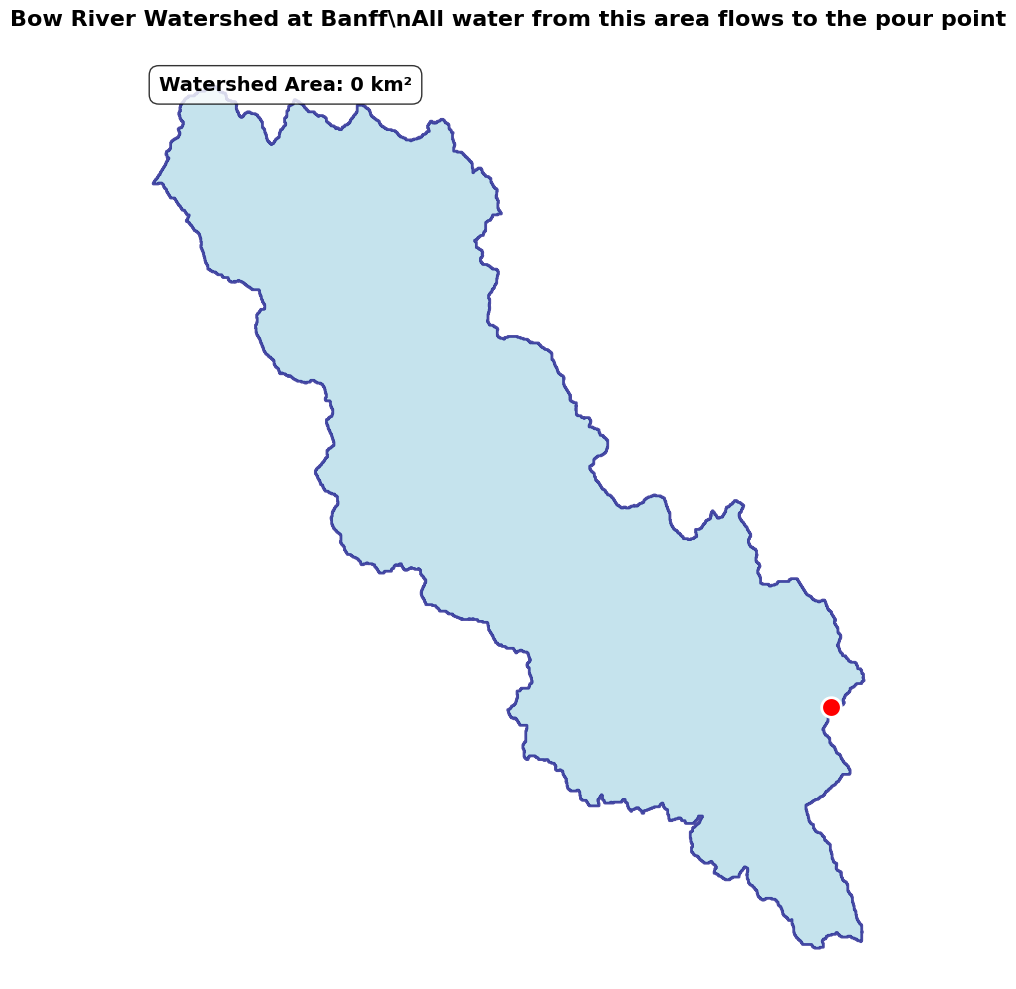

In [8]:
# Visualize the watershed
basin_path = project_dir / 'shapefiles' / 'river_basins'
if basin_path.exists():
    basin_files = list(basin_path.glob('*.shp'))
    
    if basin_files:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Load watershed and pour point
        basin_gdf = gpd.read_file(basin_files[0])
        pour_point_gdf = gpd.read_file(pour_point_path)
        
        # Reproject for visualization
        basin_web = basin_gdf.to_crs(epsg=3857)
        pour_web = pour_point_gdf.to_crs(epsg=3857)
        
        # Plot watershed
        basin_web.plot(ax=ax, facecolor='lightblue', edgecolor='navy', 
                       linewidth=2, alpha=0.7)
        
        # Add pour point
        pour_web.plot(ax=ax, color='red', markersize=200, marker='o', 
                      edgecolor='white', linewidth=2, zorder=5)
                
        # Set extent
        minx, miny, maxx, maxy = basin_web.total_bounds
        pad = 5000
        ax.set_xlim(minx - pad, maxx + pad)
        ax.set_ylim(miny - pad, maxy + pad)
        
        # Add labels
        ax.text(minx + 1000, maxy - 1000,
                f'Watershed Area: {basin_gdf.geometry.area.sum() / 1e6:.0f} km²', 
                fontsize=14, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
                fontweight='bold')
        
        ax.set_title('Bow River Watershed at Banff\\nAll water from this area flows to the pour point', 
                    fontsize=16, fontweight='bold', pad=20)
        
        ax.axis('off')
        plt.tight_layout()
        plt.show()

## 8. Step 3: Model Agnostic Data Pre-Processing
For a lumped model, the entire watershed becomes a single Hydrologic Response Unit (HRU). This simplification assumes uniform characteristics across the watershed - obviously an approximation, but useful for many applications.


In [ ]:
# Step 3: Model Agnostic Data Pre-Processing
print("=== Step 3: Model Agnostic Data Pre-Processing ===")

# Process observed data
print("Processing observed streamflow data...")
confluence.managers['data'].process_observed_data()

# Acquire forcings
print(f"\nAcquiring forcing data: {confluence.config['FORCING_DATASET']}")
confluence.managers['data'].acquire_forcings()

# Run model-agnostic preprocessing
print("\nRunning model-agnostic preprocessing...")
confluence.managers['data'].run_model_agnostic_preprocessing()

# Run benchmarking
print("\nRunning benchmarking analysis...")
benchmark_results = confluence.managers['analysis'].run_benchmarking()

print("\nModel-agnostic preprocessing complete")

## 9: Visualize observed streamflow data

In [ ]:
# Visualize observed streamflow data
obs_path = project_dir / 'observations' / 'streamflow' / 'preprocessed' / f"{confluence.config['DOMAIN_NAME']}_streamflow_processed.csv"
if obs_path.exists():
    obs_df = pd.read_csv(obs_path)
    obs_df['datetime'] = pd.to_datetime(obs_df['datetime'])
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(obs_df['datetime'], obs_df['discharge_cms'], 
            linewidth=1.5, color='blue', alpha=0.7)
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Discharge (m³/s)', fontsize=12)
    ax.set_title(f'Observed Streamflow - Bow River at Banff (WSC Station: {confluence.config["STATION_ID"]})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    ax.text(0.02, 0.95, f'Mean: {obs_df["discharge_cms"].mean():.1f} m³/s\\nMax: {obs_df["discharge_cms"].max():.1f} m³/s', 
            transform=ax.transAxes, 
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

## 12. Step 9: Model-Specific Preprocessing
Now we prepare inputs specific to our chosen hydrological model (SUMMA in this case). Each model has its own requirements for input format and configuration.

In [ ]:
# Step 4: Model Specific Processing and Initialization
print("=== Step 4: Model Specific Processing and Initialization ===")

# Preprocess models
print(f"Preparing {confluence.config['HYDROLOGICAL_MODEL']} input files...")
confluence.managers['model'].preprocess_models()

# Run models
print(f"\nRunning {confluence.config['HYDROLOGICAL_MODEL']} model...")
confluence.managers['model'].run_models()

print("\nModel run complete")

## 10: Optional Steps - Optimization and Analysis

In [ ]:
# Step 5 & 6: Optional Steps (Optimization and Analysis)
print("=== Step 5 & 6: Optional Steps ===")

# Check if optimization is enabled
if confluence.config.get('RUN_ITERATIVE_OPTIMISATION', False):
    print("Running model calibration...")
    optimization_results = confluence.managers['optimization'].calibrate_model()
else:
    print("Model calibration skipped (RUN_ITERATIVE_OPTIMISATION = False)")

# Check if emulation is enabled
if confluence.config.get('RUN_LARGE_SAMPLE_EMULATION', False) or confluence.config.get('RUN_RANDOM_FOREST_EMULATION', False):
    print("Running parameter emulation...")
    emulation_results = confluence.managers['optimization'].run_emulation()
else:
    print("Parameter emulation skipped")

# Check if decision analysis is enabled
if confluence.config.get('RUN_DECISION_ANALYSIS', False):
    print("Running decision analysis...")
    decision_results = confluence.managers['analysis'].run_decision_analysis()
else:
    print("Decision analysis skipped")

# Check if sensitivity analysis is enabled
if confluence.config.get('RUN_SENSITIVITY_ANALYSIS', False):
    print("Running sensitivity analysis...")
    sensitivity_results = confluence.managers['analysis'].run_sensitivity_analysis()
else:
    print("Sensitivity analysis skipped")

## 11: Step 7 - Result Analysis and Evaluation

In [ ]:
# Step 7: Result Analysis and Evaluation
print("=== Step 7: Result Analysis and Evaluation ===")

# Postprocess results
print("Post-processing model results...")
confluence.managers['model'].postprocess_results()

# Get workflow status
status = confluence.workflow_orchestrator.get_workflow_status()
print(f"\nWorkflow Status:")
print(f"Total steps: {status['total_steps']}")
print(f"Completed steps: {status['completed_steps']}")
print(f"Pending steps: {status['pending_steps']}")

# Display final summary
print("\n=== Workflow Complete ===")
print(f"Project: {confluence.config['DOMAIN_NAME']}")
print(f"Experiment: {confluence.config['EXPERIMENT_ID']}")
print(f"Model: {confluence.config['HYDROLOGICAL_MODEL']}")
print(f"\nKey outputs:")
print(f"  - Watershed boundary: {project_dir}/shapefiles/river_basins/")
print(f"  - Model configuration: {project_dir}/settings/{confluence.config['HYDROLOGICAL_MODEL']}/")
print(f"  - Simulation results: {project_dir}/simulations/{confluence.config['EXPERIMENT_ID']}/")
print(f"  - Performance metrics: {project_dir}/evaluation/")
print(f"  - Visualizations: {project_dir}/plots/")

## 12: Alternative - Run Complete Workflow

In [ ]:
# Alternative: Run the complete workflow in one step
# (Uncomment to use this instead of the step-by-step approach)

# confluence.run_workflow()

## 15. Summary: Understanding the CONFLUENCE Workflow
Congratulations! You've completed a full lumped basin modeling workflow with CONFLUENCE. Let's reflect on what we accomplished and how CONFLUENCE helped navigate the complex decision tree of hydrological modeling.
The Decision Tree We Navigated:

### Project Organization: Established a consistent structure for all files
Domain Definition: From pour point → watershed boundary → single HRU
Data Acquisition: Gathered forcing data, observations, and static attributes
Model Configuration: Set up SUMMA with appropriate parameters
Simulation: Ran the model for our specified period
Evaluation: Compared results with observations

## How CONFLUENCE Helped:

### Standardized each step into a clear, reproducible process
Handled complex data transformations behind the scenes
Maintained consistency across different data sources and formats
Provided sensible defaults while allowing customization
Created a complete record of all decisions and processes

## Next Steps You Could Try:

### Experiment with different models (change HYDROLOGICAL_MODEL)
Try distributed modeling (change SPATIAL_MODE to 'Distributed')
Calibrate the model (use the optimization module)
Analyze model sensitivity to different parameters
Compare multiple model structures (decision analysis)
